KeyError: 'true'

<Figure size 1000x1200 with 0 Axes>

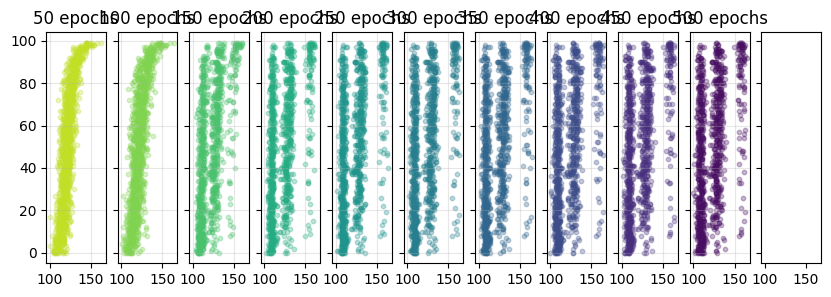

In [26]:
import pickle as pkl


eval_caches = {}
eval_caches_unconditioned = {}
epochs = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
for n_epochs in epochs:
    with open(f"/orcd/data/omarabu/001/njwfish/counting_flows/outputs/3f4cdb29c3c5/sum_conditioned/n_steps=10,n_epochs={n_epochs}/evaluation_cache.pkl", "rb") as f:
        eval_caches[n_epochs] = pkl.load(f)
    with open(f"/orcd/data/omarabu/001/njwfish/counting_flows/outputs/3f4cdb29c3c5/n_steps=10,n_epochs={n_epochs}/evaluation_cache.pkl", "rb") as f:
        eval_caches_unconditioned[n_epochs] = pkl.load(f)


groups = {}
groups_unconditioned = {}
for n_epochs in epochs:
    groups[n_epochs] = eval_caches[n_epochs]['eval_data']['x0_generated'].reshape(100, 10)
    idx = groups[n_epochs].sum(axis=1).argsort()
    groups[n_epochs] = groups[n_epochs][idx]

    groups_unconditioned[n_epochs] = eval_caches_unconditioned[n_epochs]['eval_data']['x0_generated'].reshape(100, 10)
    idx = groups_unconditioned[n_epochs].sum(axis=1).argsort()
    groups_unconditioned[n_epochs] = groups_unconditioned[n_epochs][idx]

groups['True'] = eval_caches[max(epochs)]['eval_data']['x0_target'].reshape(100, 10)
idx = groups['True'].sum(axis=1).argsort()
groups['True'] = groups['True'][idx]

groups_unconditioned['True'] = eval_caches_unconditioned[max(epochs)]['eval_data']['x0_target'].reshape(100, 10)
idx = groups_unconditioned['True'].sum(axis=1).argsort()
groups_unconditioned['True'] = groups_unconditioned['True'][idx]

from matplotlib import pyplot as plt
# Dotplot with groups sorted by mean
plt.figure(figsize=(10, 12))
fig, axs = plt.subplots(1, len(epochs) + 1, figsize=(10, 3), sharey=True, sharex=True)
for j, n_epochs in enumerate(epochs):
    # set color based on n_epochs
    color = plt.cm.viridis(1 - n_epochs / (max(epochs) + 20))
    for i, group in enumerate(groups[n_epochs]):
        axs[j].scatter(group, [i]*10, color=color, alpha=0.3, s=10)
    axs[j].grid(alpha=0.3)
    axs[j].set_title(f"{n_epochs} epochs")


for i, group in enumerate(groups['true']):
    axs[-1].scatter(group, [i]*10, color='black', alpha=0.3, s=10)
axs[-1].set_title("True")

axs[0].set_ylabel("Group")

# axs[0].set_xlim(10, 200)

fig.tight_layout()
fig.show()


<Axes: ylabel='Density'>

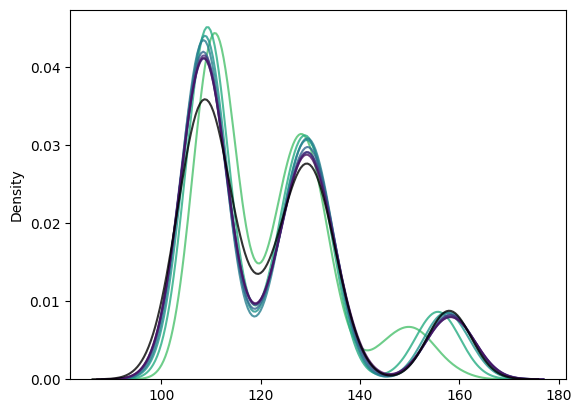

In [ ]:
import seaborn as sns
# plot density of difference between sum of groups
for n_epochs in epochs[2:]:
    color = plt.cm.viridis(1 - n_epochs / (max(epochs) + 20))
    # use kde to plot density
    sns.kdeplot(groups[n_epochs].flatten(), color=color, alpha=0.8)

# plot vertical line at 0
sns.kdeplot(groups['true'].flatten(), color='black', alpha=0.8)


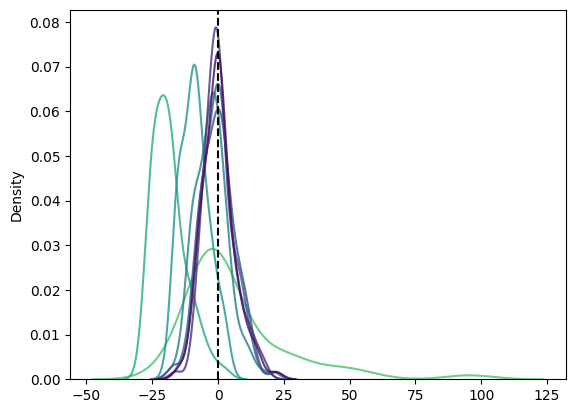

In [ ]:
import seaborn as sns
# plot density of difference between sum of groups
for n_epochs in epochs[2:]:
    color = plt.cm.viridis(1 - n_epochs / (max(epochs) + 20))
    # use kde to plot density
    sns.kdeplot(groups['true'].sum(axis=1) - groups_unconditioned[n_epochs].sum(axis=1), color=color, alpha=0.8)

# plot vertical line at 0
plt.axvline(0, color='black', linestyle='--')

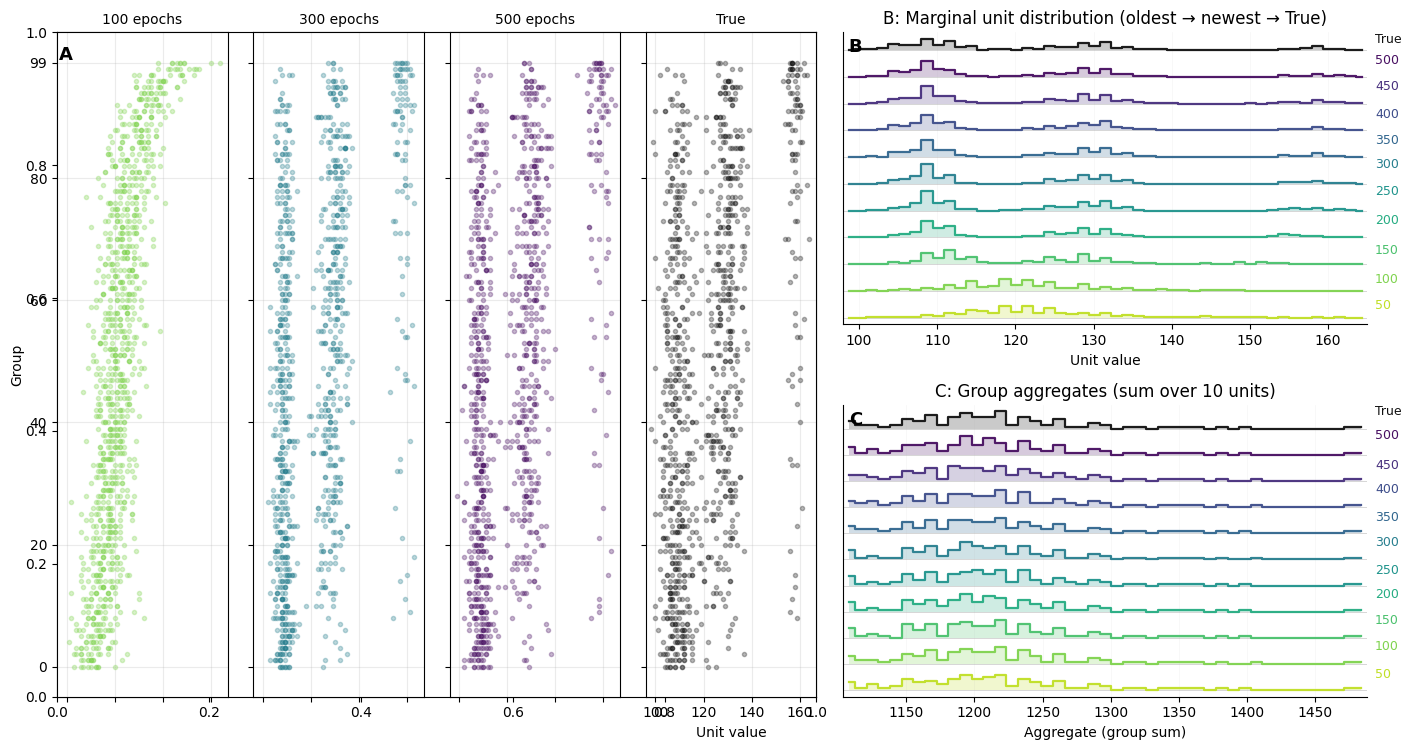

In [ ]:
# --- Figure 2 (final: A dotplots, B unit ridgelines, C aggregate ridgelines) ---
# expects: eval_caches, epochs (as before)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

viridis = mpl.colormaps["viridis"]

def nice(ax):
    ax.grid(True, alpha=0.18, linewidth=0.55)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

def epoch_color(ep, epochs):  # early->green, late->purple; truth handled separately
    t = 1.0 - (ep / (max(epochs) + 20.0))
    return viridis(float(t))

def sorted_groups(x0_vec, G=100, group_size=10):
    X = x0_vec.reshape(G, group_size).copy()
    idx = X.sum(axis=1).argsort()
    return X[idx]

def draw_ridgelines(ax, order_keys, arrays_by_key, colors_by_key,
                    bins, title, xlabel, fill_alpha=0.22, lw=1.6, right_labels=None):
    # histograms + max height
    H = {}
    hmax = 0.0
    for k in order_keys:
        arr = arrays_by_key[k]
        h, edges = np.histogram(arr, bins=bins, density=True)
        H[k] = (h, edges)
        if h.size: hmax = max(hmax, float(h.max()))
    if hmax == 0: hmax = 0.2
    gap = 1.35*hmax
    ymax = 0.0

    # baselines
    for j, k in enumerate(order_keys):
        y0 = j*gap
        ax.hlines(y0, bins[0], bins[-1], color="#d0d0d0", lw=0.6, zorder=0)

    # ridges (TOP = first element in order_keys)
    for j, k in enumerate(order_keys):
        h, edges = H[k]; y0 = j*gap
        if h.size == 0: continue
        x_mid = 0.5*(edges[:-1] + edges[1:])
        col = colors_by_key[k]
        ax.fill_between(x_mid, y0, y0+h, step="mid",
                        color=col, alpha=fill_alpha, linewidth=0.0, zorder=1)
        ax.plot(x_mid, y0+h, drawstyle="steps-mid", lw=lw, color=col, alpha=0.95, zorder=2)
        lab = (right_labels(k) if right_labels else str(k))
        ax.text(bins[-1] + 0.015*(bins[-1]-bins[0]),
                y0 + h.max(), lab, ha="left", va="center", fontsize=9, color=col)
        ymax = max(ymax, y0 + float(h.max()))

    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(-gap*0.25, ymax + gap*0.25)
    ax.set_yticks([]); ax.set_ylabel("")
    ax.set_xlabel(xlabel); ax.set_title(title)
    ax.grid(True, alpha=0.12, linewidth=0.5)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

# ---------------- data prep ----------------
G, group_size = 100, 10
epochs_sorted = sorted(epochs)                      # 50,...,500
order_top_to_bottom = epochs_sorted + ["True"]      # TOP=earliest ... BOTTOM=True

groups = {}
for ep in epochs_sorted:
    groups[ep] = sorted_groups(eval_caches[ep]["eval_data"]["x0_generated"], G, group_size)
x0_true = eval_caches[epochs_sorted[-1]]["eval_data"]["x0_target"]
groups["True"] = sorted_groups(x0_true, G, group_size)

colors = {ep: epoch_color(ep, epochs_sorted) for ep in epochs_sorted}
colors["True"] = "#111111"

# ---------------- figure ----------------
plt.close("all")
fig = plt.figure(figsize=(14.2, 7.6))
gs  = GridSpec(nrows=2, ncols=2, width_ratios=[1.45, 1.0], height_ratios=[1., 1.], figure=fig)

# A — dotplots (choose 3 epochs + True); one shared y-axis & shared x-lims
axA_big = fig.add_subplot(gs[:, 0])
sub = gs[:, 0].subgridspec(1, 4, wspace=0.15)
chosen = [epochs_sorted[1], epochs_sorted[len(epochs_sorted)//2], epochs_sorted[-1], "True"]  # e.g. 100, 300, 500, True

all_vals = np.concatenate([groups[k].ravel() for k in chosen])
xmin, xmax = all_vals.min(), all_vals.max()
pad = 0.03 * (xmax - xmin + 1e-9)
xlim = (xmin - pad, xmax + pad)

ref = None
for j, key in enumerate(chosen):
    ax = fig.add_subplot(sub[0, j], sharey=ref)
    if ref is None: ref = ax
    X = groups[key]; col = colors[key]
    for i, g in enumerate(X):
        ax.scatter(g, np.full(group_size, i), s=9, color=col, alpha=0.30, zorder=2)
    ax.set_xlim(*xlim)
    ax.set_title(f"{key} epochs" if key != "True" else "True", fontsize=10)
    ax.grid(alpha=0.25)
    if j == 0:
        ax.set_ylabel("Group"); ax.set_yticks([0,20,40,60,80,99])
    else:
        ax.tick_params(axis='y', labelleft=False)
    if j < len(chosen)-1:
        ax.set_xlabel("")
        ax.tick_params(axis='x', labelbottom=False)
    else:
        ax.set_xlabel("Unit value")

# left panel label
ref.text(0.01, 0.98, "A", transform=ref.transAxes, ha="left", va="top",
         fontsize=13, weight="bold")

# B — ridgelines of unit values, top→bottom = earliest→latest→True
axB = fig.add_subplot(gs[0, 1])
marginals = {k: groups[k].ravel() for k in order_top_to_bottom}
vals = np.concatenate([marginals[k] for k in order_top_to_bottom])
bins_units = np.linspace(vals.min(), vals.max(), 48)
draw_ridgelines(
    axB, order_top_to_bottom, marginals, colors, bins_units,
    title="B: Marginal unit distribution (oldest → newest → True)",
    xlabel="Unit value",
    right_labels=lambda k: ("True" if k == "True" else f"{k}")
)
axB.text(0.01, 0.98, "B", transform=axB.transAxes, ha="left", va="top",
         fontsize=13, weight="bold")

# C — ridgelines of group sums, same order (epochs on bottom should hug truth)
axC = fig.add_subplot(gs[1, 1])
sums_by_key = {k: groups[k].sum(axis=1) for k in order_top_to_bottom}
S = np.concatenate([sums_by_key[k] for k in order_top_to_bottom])
bins_sums = np.linspace(S.min(), S.max(), 46)
draw_ridgelines(
    axC, order_top_to_bottom, sums_by_key, colors, bins_sums,
    title="C: Group aggregates (sum over 10 units)",
    xlabel="Aggregate (group sum)",
    right_labels=lambda k: ("True" if k == "True" else f"{k}")
)
axC.text(0.01, 0.98, "C", transform=axC.transAxes, ha="left", va="top",
         fontsize=13, weight="bold")

# add note if aggregates match visually
if np.allclose(sums_by_key["True"].mean(), sums_by_key[epochs_sorted[-1]].mean(), rtol=0, atol=1e-9):
    axC.text(0.5, -0.18, "Latest epoch aggregates overlap Truth (to plotting precision)",
             transform=axC.transAxes, ha="center", va="top", fontsize=9, color="#333")

plt.tight_layout()
plt.show()


Ridgeline order top→bottom: [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 'True']


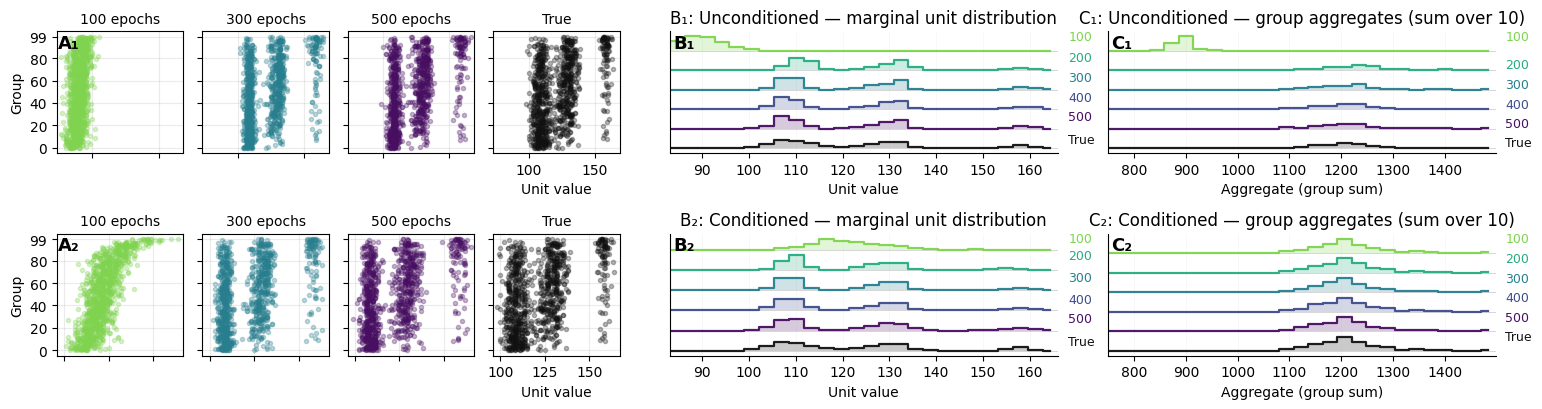

In [41]:
# === Figure 2: Unconditioned (top row) vs Conditioned (bottom row) ===========
# Panels per row: A(dotplots), B(unit ridgelines), C(aggregate ridgelines)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

viridis = mpl.colormaps["viridis"]

# ---------------- helpers ----------------
def nice(ax):
    ax.grid(True, alpha=0.18, linewidth=0.55)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

def epoch_color(ep, epochs_sorted):  # early→green, late→purple
    t = 1.0 - (ep / (epochs_sorted[-1] + 20.0))
    return viridis(float(t))

def sorted_groups(x0_vec, G=100, group_size=10):
    X = x0_vec.reshape(G, group_size).copy()
    idx = X.sum(axis=1).argsort()
    return X[idx]

def draw_ridgelines(ax, order_keys, arrays_by_key, colors_by_key,
                    bins, title, xlabel, fill_alpha=0.22, lw=1.6, right_labels=None):
    order_keys = [100, 200, 300, 400, 500, 'True']
    H, hmax = {}, 0.0
    for k in order_keys:
        arr = arrays_by_key[k]
        h, edges = np.histogram(arr, bins=bins, density=True)
        H[k] = (h, edges)
        if h.size: hmax = max(hmax, float(h.max()))
    if hmax == 0: hmax = 0.2
    gap = 1.35*hmax
    ymax = 0.0

    # baselines
    for j, _ in enumerate(reversed(order_keys)):
        y0 = j*gap
        ax.hlines(y0, bins[0], bins[-1], color="#d0d0d0", lw=0.6, zorder=0)

    # ridges (TOP = first element)
    for j, k in enumerate(reversed(order_keys)):
        h, edges = H[k]; y0 = j*gap
        if h.size == 0: continue
        x_mid = 0.5*(edges[:-1] + edges[1:])
        col = colors_by_key[k]
        ax.fill_between(x_mid, y0, y0+h, step="mid",
                        color=col, alpha=fill_alpha, linewidth=0.0, zorder=1)
        ax.plot(x_mid, y0+h, drawstyle="steps-mid", lw=lw, color=col, alpha=0.95, zorder=2)
        lab = (right_labels(k) if right_labels else str(k))
        ax.text(bins[-1] + 0.015*(bins[-1]-bins[0]), y0 + h.max(),
                lab, ha="left", va="center", fontsize=9, color=col)
        ymax = max(ymax, y0 + float(h.max()))

    ax.set_xlim(bins[-1] * 0.5, bins[-1])
    ax.set_ylim(-gap*0.25, ymax + gap*0.25)
    ax.set_yticks([]); ax.set_ylabel("")
    ax.set_xlabel(xlabel); ax.set_title(title)
    ax.grid(True, alpha=0.12, linewidth=0.5)
    ax.spines["top"].set_visible(False); ax.spines["right"].set_visible(False)

def build_groups_dicts(eval_caches, epochs_sorted, G=100, group_size=10):
    groups = {}
    for ep in epochs_sorted:
        groups[ep] = sorted_groups(eval_caches[ep]["eval_data"]["x0_generated"], G, group_size)
    # Truth from target in the last epoch cache
    x0_true = eval_caches[epochs_sorted[-1]]["eval_data"]["x0_target"]
    groups["True"] = sorted_groups(x0_true, G, group_size)
    return groups

def colors_for_epochs(epochs_sorted):
    colors = {ep: epoch_color(ep, epochs_sorted) for ep in epochs_sorted}
    colors["True"] = "#111111"
    return colors

def draw_dotplots_panel(parent_spec, groups_dict, chosen_keys, colors):
    # 4 slim subplots inside one A panel
    sub = parent_spec.subgridspec(1, 4, wspace=0.15)
    # shared x-lims over chosen columns
    all_vals = np.concatenate([groups_dict[k].ravel() for k in chosen_keys])
    xmin, xmax = all_vals.min(), all_vals.max()
    pad = 0.03*(xmax - xmin + 1e-9)
    xlim = (xmin - pad, xmax + pad)

    ref_ax = None
    axes = []
    for j, key in enumerate(chosen_keys):
        ax = plt.subplot(sub[0, j], sharey=ref_ax)
        if ref_ax is None: ref_ax = ax
        X = groups_dict[key]; col = colors[key]
        for i, g in enumerate(X):
            ax.scatter(g, np.full(g.shape[0], i), s=9, color=col, alpha=0.30, zorder=2)
        ax.set_xlim(*xlim)
        ax.set_title(f"{key} epochs" if key != "True" else "True", fontsize=10)
        ax.grid(alpha=0.25)
        if j == 0:
            ax.set_ylabel("Group"); ax.set_yticks([0,20,40,60,80,99])
        else:
            ax.tick_params(axis='y', labelleft=False)
        if j < len(chosen_keys)-1:
            ax.set_xlabel(""); ax.tick_params(axis='x', labelbottom=False)
        else:
            ax.set_xlabel("Unit value")
        axes.append(ax)
    return axes[0]  # return first sub-axes for placing the "A" label

# ---------------- inputs you already have ----------------
# epochs_list = [50,100,150,200,250,300,350,400,450,500]  # example
# eval_caches, eval_caches_unconditioned

epochs_list = epochs  # use your provided variable
epochs_sorted = sorted(epochs_list)

# Build conditioned / unconditioned groups dicts
groups_cond = build_groups_dicts(eval_caches, epochs_sorted)
groups_uncond = build_groups_dicts(eval_caches_unconditioned, epochs_sorted)

# Color map shared for both rows
colors = colors_for_epochs(epochs_sorted)

# Order for ridgelines: oldest … latest … True  (True last = bottom)
order_top_to_bottom = epochs_sorted + ["True"]
print("Ridgeline order top→bottom:", order_top_to_bottom)  # sanity print

# Choose epochs to show in dotplots
chosen = [epochs_sorted[1], epochs_sorted[len(epochs_sorted)//2], epochs_sorted[-1], "True"]
# e.g. [100, 300, 500, "True"] if the list is [50,...,500]

# ---------------- figure ----------------
plt.close("all")
fig = plt.figure(figsize=(15.5, 4.2))
gs = GridSpec(nrows=2, ncols=3, width_ratios=[1.45, 1.0, 1.0],
              height_ratios=[1., 1.], figure=fig)

# ===== ROW 1: UNCONDITIONED ===================================================
# A_u
A_u_spec = gs[0, 0]
axA_u_big = plt.subplot(A_u_spec)  # host, we’ll fill with subgridspec
axA_u_big.axis("off")              # the content goes to sub-axes
axA_u_ref = draw_dotplots_panel(A_u_spec, groups_uncond, chosen, colors)
axA_u_ref.text(0.01, 0.98, "A\u2081", transform=axA_u_ref.transAxes,
               ha="left", va="top", fontsize=13, weight="bold")  # A₁

# B_u (unit ridgelines)
axB_u = plt.subplot(gs[0, 1])
marg_u = {k: groups_uncond[k].ravel() for k in order_top_to_bottom}
vals_u = np.concatenate([marg_u[k] for k in order_top_to_bottom])
bins_units_u = np.linspace(vals_u.min(), vals_u.max(), 48)
draw_ridgelines(
    axB_u, order_top_to_bottom, marg_u, colors, bins_units_u,
    title="B\u2081: Unconditioned — marginal unit distribution",
    xlabel="Unit value",
    right_labels=lambda k: ("True" if k == "True" else f"{k}")
)
axB_u.text(0.01, 0.98, "B\u2081", transform=axB_u.transAxes, ha="left", va="top",
           fontsize=13, weight="bold")

# C_u (aggregate ridgelines)
axC_u = plt.subplot(gs[0, 2])
sums_u = {k: groups_uncond[k].sum(axis=1) for k in order_top_to_bottom}
S_u = np.concatenate([sums_u[k] for k in order_top_to_bottom])
bins_sums_u = np.linspace(S_u.min(), S_u.max(), 46)
draw_ridgelines(
    axC_u, order_top_to_bottom, sums_u, colors, bins_sums_u,
    title="C\u2081: Unconditioned — group aggregates (sum over 10)",
    xlabel="Aggregate (group sum)",
    right_labels=lambda k: ("True" if k == "True" else f"{k}")
)
axC_u.text(0.01, 0.98, "C\u2081", transform=axC_u.transAxes, ha="left", va="top",
           fontsize=13, weight="bold")

# ===== ROW 2: CONDITIONED =====================================================
# A_c
A_c_spec = gs[1, 0]
axA_c_big = plt.subplot(A_c_spec)
axA_c_big.axis("off")
axA_c_ref = draw_dotplots_panel(A_c_spec, groups_cond, chosen, colors)
axA_c_ref.text(0.01, 0.98, "A\u2082", transform=axA_c_ref.transAxes,
               ha="left", va="top", fontsize=13, weight="bold")  # A₂
axA_c_ref.set_ylabel("Group")  # keep only bottom row y-label

# B_c
axB_c = plt.subplot(gs[1, 1])
marg_c = {k: groups_cond[k].ravel() for k in order_top_to_bottom}
vals_c = np.concatenate([marg_c[k] for k in order_top_to_bottom])
# Use shared bin edges across rows for fair comparison
lo = min(bins_units_u[0], vals_c.min()); hi = max(bins_units_u[-1], vals_c.max())
bins_units_c = np.linspace(lo, hi, 48)
draw_ridgelines(
    axB_c, order_top_to_bottom, marg_c, colors, bins_units_c,
    title="B\u2082: Conditioned — marginal unit distribution",
    xlabel="Unit value",
    right_labels=lambda k: ("True" if k == "True" else f"{k}")
)
axB_c.text(0.01, 0.98, "B\u2082", transform=axB_c.transAxes, ha="left", va="top",
           fontsize=13, weight="bold")

# C_c
axC_c = plt.subplot(gs[1, 2])
sums_c = {k: groups_cond[k].sum(axis=1) for k in order_top_to_bottom}
S_c = np.concatenate([sums_c[k] for k in order_top_to_bottom])
lo = min(bins_sums_u[0], S_c.min()); hi = max(bins_sums_u[-1], S_c.max())
bins_sums_c = np.linspace(lo, hi, 46)
draw_ridgelines(
    axC_c, order_top_to_bottom, sums_c, colors, bins_sums_c,
    title="C\u2082: Conditioned — group aggregates (sum over 10)",
    xlabel="Aggregate (group sum)",
    right_labels=lambda k: ("True" if k == "True" else f"{k}")
)
axC_c.text(0.01, 0.98, "C\u2082", transform=axC_c.transAxes, ha="left", va="top",
           fontsize=13, weight="bold")

plt.tight_layout()
plt.show()
